# =====  SETUP AND MOUNT GOOGLE DRIVE =====

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib


In [61]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
bookings_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/bookings_train.csv')
tasks_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/tasks.csv')
staffing_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/staffing_train.csv')

# Load test inputs


In [64]:
task1_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/Evaluation Inputs/task1_test_inputs.csv')
task2_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/Evaluation Inputs/task2_test_inputs.csv')


In [65]:
print("Dataset shapes:")
print(f"Bookings: {bookings_df.shape}")
print(f"Tasks: {tasks_df.shape}")
print(f"Staffing: {staffing_df.shape}")
print(f"Task1 Test: {task1_test.shape}")
print(f"Task2 Test: {task2_test.shape}")

Dataset shapes:
Bookings: (203693, 11)
Tasks: (19, 4)
Staffing: (5802, 4)
Task1 Test: (49906, 4)
Task2 Test: (1440, 3)


# =====  FILL TASKS DATASET (MANDATORY) =====

In [66]:
section_mapping = {
    'SEC-001': 'First-time Passport Applications',
    'SEC-002': 'Renewals and Updates',
    'SEC-003': 'Corrections and Amendments',
    'SEC-004': 'Lost/Stolen Passport Reissue',
    'SEC-005': 'Document Verification',
    'SEC-006': 'Special Cases'
}

In [67]:
print("Unique sections in data:", tasks_df['section_id'].unique())

Unique sections in data: ['SEC-001' 'SEC-002' 'SEC-003' 'SEC-004' 'SEC-005' 'SEC-006']


In [68]:
# Fill section names
for idx, row in tasks_df.iterrows():
    section_id = row['section_id']
    if section_id in section_mapping:
        tasks_df.at[idx, 'section_name'] = section_mapping[section_id]

In [69]:
# Define task names based on task_id patterns
# You need to adapt this based on your actual task_ids
task_mapping = {}
for idx, row in tasks_df.iterrows():
    task_id = row['task_id']
    section_id = row['section_id']

    # Example task naming logic - adapt this to your data
    if section_id == 'SEC-001':  # First-time Passport Applications
        if task_id in ['TASK-001', 'TASK-002']:
            task_mapping[task_id] = f"Process new passport application - {task_id}"

    elif section_id == 'SEC-002':  # Renewals and Updates
        if task_id in ['TASK-003', 'TASK-004', 'TASK-005', 'TASK-006']:
            task_mapping[task_id] = f"Handle passport renewal/update - {task_id}"

    elif section_id == 'SEC-003':  # Corrections and Amendments
        if task_id in ['TASK-007', 'TASK-008', 'TASK-009']:
            task_mapping[task_id] = f"Apply correction/amendment - {task_id}"

    elif section_id == 'SEC-004':  # Lost/Stolen Passport Reissue
        if task_id in ['TASK-010', 'TASK-011', 'TASK-012']:
            task_mapping[task_id] = f"Reissue lost/stolen passport - {task_id}"

    elif section_id == 'SEC-005':  # Document Verification
        if task_id in ['TASK-013', 'TASK-014', 'TASK-015']:
            task_mapping[task_id] = f"Verify documents - {task_id}"

    elif section_id == 'SEC-006':  # Special Cases
        if task_id in ['TASK-016', 'TASK-017', 'TASK-018', 'TASK-019']:
            task_mapping[task_id] = f"Handle special case - {task_id}"



In [70]:
# If task_mapping is empty, create generic names
if not task_mapping:
    for idx, row in tasks_df.iterrows():
        task_id = row['task_id']
        section_name = row['section_name']
        task_mapping[task_id] = f"{section_name} - Task {task_id.split('-')[1]}"

In [71]:
# Fill task names
for idx, row in tasks_df.iterrows():
    task_id = row['task_id']
    if task_id in task_mapping:
        tasks_df.at[idx, 'task_name'] = task_mapping[task_id]

In [72]:
print("Tasks dataset filled:")
print(tasks_df.head(5))

Tasks dataset filled:
    task_id                                    task_name section_id  \
0  TASK-001  Process new passport application - TASK-001    SEC-001   
1  TASK-002  Process new passport application - TASK-002    SEC-001   
2  TASK-003    Handle passport renewal/update - TASK-003    SEC-002   
3  TASK-004    Handle passport renewal/update - TASK-004    SEC-002   
4  TASK-005    Handle passport renewal/update - TASK-005    SEC-002   

                       section_name  
0  First-time Passport Applications  
1  First-time Passport Applications  
2              Renewals and Updates  
3              Renewals and Updates  
4              Renewals and Updates  


# Save filled tasks dataset

In [73]:
tasks_df.to_csv('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/tasks_filled.csv', index=False)

# DATA EXPLORATION

In [74]:
# Convert datetime columns in bookings
bookings_df['booking_date'] = pd.to_datetime(bookings_df['booking_date'])
bookings_df['appointment_date'] = pd.to_datetime(bookings_df['appointment_date'])
bookings_df['check_in_time'] = pd.to_datetime(bookings_df['check_in_time'])
bookings_df['check_out_time'] = pd.to_datetime(bookings_df['check_out_time'])

In [75]:
# Calculate processing time (TARGET for Task 1)
bookings_df['processing_time_minutes'] = (
    bookings_df['check_out_time'] - bookings_df['check_in_time']
).dt.total_seconds() / 60

In [76]:
# Remove invalid processing times
bookings_df = bookings_df[
    (bookings_df['processing_time_minutes'] > 0) &
    (bookings_df['processing_time_minutes'] < 480)  # Less than 8 hours
]

In [77]:
print(f"Processing time stats:")
print(bookings_df['processing_time_minutes'].describe())


Processing time stats:
count    197601.000000
mean         48.808690
std          24.001752
min           5.922487
25%          31.848814
50%          42.795068
75%          59.957378
max         217.635393
Name: processing_time_minutes, dtype: float64


# Visualize processing time distribution

Text(0.5, 0, 'Minutes')

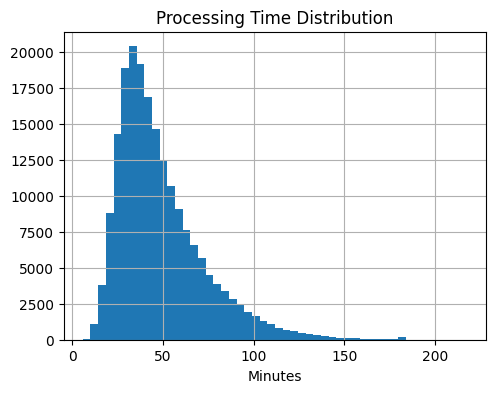

In [78]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bookings_df['processing_time_minutes'].hist(bins=50)
plt.title('Processing Time Distribution')
plt.xlabel('Minutes')

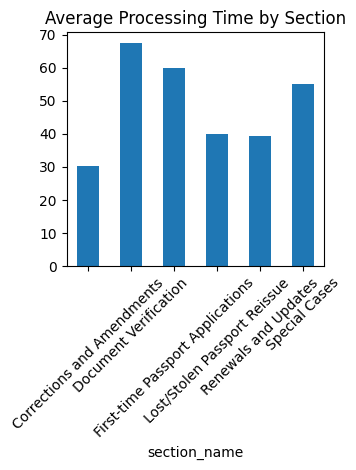

In [79]:
# Join with tasks to analyze by section
bookings_with_tasks = bookings_df.merge(tasks_df, on='task_id', how='left')

plt.subplot(1, 2, 2)
section_avg_times = bookings_with_tasks.groupby('section_name')['processing_time_minutes'].mean()
section_avg_times.plot(kind='bar')
plt.title('Average Processing Time by Section')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING FOR TASK 1

In [80]:
bookings_df['appointment_time'] = pd.to_datetime(
    bookings_df['appointment_time'], format='%H:%M'
).dt.time

# Create time-based features
bookings_df['day_of_week'] = bookings_df['appointment_date'].dt.dayofweek
bookings_df['month'] = bookings_df['appointment_date'].dt.month
bookings_df['hour'] = pd.to_datetime(
    bookings_df['appointment_time'], format='%H:%M:%S'
).dt.hour
bookings_df['is_weekend'] = bookings_df['day_of_week'].isin([5, 6]).astype(int)


In [81]:
# Join with tasks information
task1_df = bookings_df.merge(tasks_df, on='task_id', how='left')

# Encode categorical variables
le_task = LabelEncoder()
le_section = LabelEncoder()

# Fit encoders on all possible values
all_task_ids = list(set(tasks_df['task_id'].unique()) | set(task1_test['task_id'].unique()))
all_section_ids = list(set(tasks_df['section_id'].unique()) | set(task2_test['section_id'].unique()))

le_task.fit(all_task_ids)
le_section.fit(all_section_ids)

task1_df['task_id_encoded'] = le_task.transform(task1_df['task_id'])
task1_df['section_id_encoded'] = le_section.transform(task1_df['section_id'])


# Calculate historical averages
task_avg_time = task1_df.groupby('task_id')['processing_time_minutes'].mean()
section_avg_time = task1_df.groupby('section_id')['processing_time_minutes'].mean()
hour_avg_time = task1_df.groupby('hour')['processing_time_minutes'].mean()

task1_df['task_avg_time'] = task1_df['task_id'].map(task_avg_time)
task1_df['section_avg_time'] = task1_df['section_id'].map(section_avg_time)
task1_df['hour_avg_time'] = task1_df['hour'].map(hour_avg_time)



# TRAIN TASK 1 MODEL

In [82]:
features_task1 = [
    'day_of_week', 'month', 'hour', 'is_weekend',
    'task_id_encoded', 'section_id_encoded', 'num_documents',
    'queue_number', 'task_avg_time', 'section_avg_time', 'hour_avg_time'
]

# Prepare data
X_task1 = task1_df[features_task1].fillna(0)
y_task1 = task1_df['processing_time_minutes']

# Split data
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_task1, y_task1, test_size=0.2, random_state=42
)

# Train Random Forest model
model_task1 = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

In [83]:
model_task1.fit(X_train1, y_train1)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [84]:
# Evaluate Task 1 model
y_pred1 = model_task1.predict(X_test1)
rmse1 = np.sqrt(mean_squared_error(y_test1, y_pred1))
mae1 = mean_absolute_error(y_test1, y_pred1)


In [85]:
print(f"Task 1 Model Performance:")
print(f"RMSE: {rmse1:.2f} minutes")
print(f"MAE: {mae1:.2f} minutes")


Task 1 Model Performance:
RMSE: 15.32 minutes
MAE: 10.40 minutes


In [86]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_task1,
    'importance': model_task1.feature_importances_
}).sort_values('importance', ascending=False)

In [87]:
print("\nTop 5 Important Features for Task 1:")
print(feature_importance.head())


Top 5 Important Features for Task 1:
         feature  importance
8  task_avg_time    0.810906
7   queue_number    0.049788
1          month    0.035504
6  num_documents    0.034974
0    day_of_week    0.025493


 # FEATURE ENGINEERING FOR TASK 2

In [88]:

# Prepare staffing dataset
staffing_df['date'] = pd.to_datetime(staffing_df['date'])
staffing_df['day_of_week'] = staffing_df['date'].dt.dayofweek
staffing_df['month'] = staffing_df['date'].dt.month
staffing_df['is_weekend'] = staffing_df['day_of_week'].isin([5, 6]).astype(int)

# Calculate workload metrics
staffing_df['avg_task_time_per_employee'] = (
    staffing_df['total_task_time_minutes'] / staffing_df['employees_on_duty']
).replace([np.inf, -np.inf], 0)

# Historical patterns
section_avg_employees = staffing_df.groupby('section_id')['employees_on_duty'].mean()
section_avg_workload = staffing_df.groupby('section_id')['total_task_time_minutes'].mean()

staffing_df['section_avg_employees'] = staffing_df['section_id'].map(section_avg_employees)
staffing_df['section_avg_workload'] = staffing_df['section_id'].map(section_avg_workload)

# Encode section_id using the same encoder
staffing_df['section_id_encoded'] = le_section.transform(staffing_df['section_id'])


# TRAIN TASK 2 MODEL

In [89]:
features_task2 = [
    'day_of_week', 'month', 'is_weekend', 'section_id_encoded',
    'total_task_time_minutes', 'section_avg_employees', 'section_avg_workload'
]

# Prepare data
X_task2 = staffing_df[features_task2].fillna(0)
y_task2 = staffing_df['employees_on_duty']

# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_task2, y_task2, test_size=0.2, random_state=42
)

# Train Random Forest model
model_task2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

In [90]:
model_task2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [91]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_task2,
    'importance': model_task2.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features for Task 2:")
print(feature_importance.head())


Top 5 Important Features for Task 2:
                   feature  importance
4  total_task_time_minutes    0.981435
1                    month    0.008560
0              day_of_week    0.004496
3       section_id_encoded    0.002285
5    section_avg_employees    0.001633


In [92]:
# Evaluate Task 2 model
y_pred2 = model_task2.predict(X_test2)
rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
mae2 = mean_absolute_error(y_test2, y_pred2)

print(f"Task 2 Model Performance:")
print(f"RMSE: {rmse2:.2f} employees")
print(f"MAE: {mae2:.2f} employees")


Task 2 Model Performance:
RMSE: 0.67 employees
MAE: 0.51 employees


# GENERATE TASK 1 PREDICTIONS

In [93]:
# Prepare Task 1 test data
task1_test_processed = task1_test.copy()
task1_test_processed['date'] = pd.to_datetime(task1_test_processed['date'])
task1_test_processed['time'] = pd.to_datetime(task1_test_processed['time'], format='%H:%M').dt.time

# Extract features
task1_test_processed['day_of_week'] = task1_test_processed['date'].dt.dayofweek
task1_test_processed['month'] = task1_test_processed['date'].dt.month
task1_test_processed['hour'] = pd.to_datetime(
    task1_test_processed['time'], format='%H:%M:%S'
).dt.hour
task1_test_processed['is_weekend'] = task1_test_processed['day_of_week'].isin([5, 6]).astype(int)

# Handle unseen task_ids
def safe_transform(encoder, values, default_value=-1):
    result = []
    for value in values:
        try:
            result.append(encoder.transform([value])[0])
        except:
            result.append(default_value)
    return np.array(result)

task1_test_processed['task_id_encoded'] = safe_transform(le_task, task1_test_processed['task_id'])

# Get section_id from tasks mapping
task1_test_processed = task1_test_processed.merge(
    tasks_df[['task_id', 'section_id']],
    on='task_id',
    how='left'
)


In [94]:
# Fill missing section_ids with most common
most_common_section = tasks_df['section_id'].mode()[0]
task1_test_processed['section_id'] = task1_test_processed['section_id'].fillna(most_common_section)

task1_test_processed['section_id_encoded'] = safe_transform(
    le_section,
    task1_test_processed['section_id']
)

# Add historical averages and defaults
task1_test_processed['task_avg_time'] = task1_test_processed['task_id'].map(
    task_avg_time
).fillna(task_avg_time.mean())

task1_test_processed['section_avg_time'] = task1_test_processed['section_id'].map(
    section_avg_time
).fillna(section_avg_time.mean())

task1_test_processed['hour_avg_time'] = task1_test_processed['hour'].map(
    hour_avg_time
).fillna(hour_avg_time.mean())


In [95]:
# Default values for missing features
task1_test_processed['num_documents'] = 2  # Average assumption
task1_test_processed['queue_number'] = 5   # Average assumption

# Make predictions
X_test_task1 = task1_test_processed[features_task1].fillna(0)
predictions_task1 = model_task1.predict(X_test_task1)

# Create Task 1 submission
task1_submission = pd.DataFrame({
    'row_id': task1_test['row_id'],
    'true_processing_time_minutes': np.maximum(1, predictions_task1.round().astype(int))
})

print(f"Task 1 predictions sample:")
print(task1_submission.head())

Task 1 predictions sample:
                                     row_id  true_processing_time_minutes
0  a19eed30dfbab7586131ca2329207b9cff81d5d5                            54
1  8da6066c865c7053bb39092977fc0e513e045159                            30
2  0cec7d70a44a71f0ceb7f78fabd2d0fef1439649                            79
3  de2e5611033bbae4fb959d008455103b2da53e01                            23
4  40736d54ee59e94c3dc5f34127d160db395805a3                            48


# GENERATE TASK 2 PREDICTIONS

In [96]:
# Prepare Task 2 test data
task2_test_processed = task2_test.copy()
task2_test_processed['date'] = pd.to_datetime(task2_test_processed['date'])

# Extract features
task2_test_processed['day_of_week'] = task2_test_processed['date'].dt.dayofweek
task2_test_processed['month'] = task2_test_processed['date'].dt.month
task2_test_processed['is_weekend'] = task2_test_processed['day_of_week'].isin([5, 6]).astype(int)

# Encode section_id
task2_test_processed['section_id_encoded'] = safe_transform(
    le_section,
    task2_test_processed['section_id']
)

# Add historical averages
task2_test_processed['section_avg_employees'] = task2_test_processed['section_id'].map(
    section_avg_employees
).fillna(section_avg_employees.mean())

task2_test_processed['section_avg_workload'] = task2_test_processed['section_id'].map(
    section_avg_workload
).fillna(section_avg_workload.mean())

In [97]:
# Default workload assumption
task2_test_processed['total_task_time_minutes'] = task2_test_processed['section_avg_workload']

# Make predictions
X_test_task2 = task2_test_processed[features_task2].fillna(0)
predictions_task2 = model_task2.predict(X_test_task2)

# Create Task 2 submission
task2_submission = pd.DataFrame({
    'row_id': task2_test['row_id'],
    'true_required_employees': np.maximum(1, predictions_task2.round().astype(int))
})

print(f"Task 2 predictions sample:")
print(task2_submission.head())

Task 2 predictions sample:
                                     row_id  true_required_employees
0  f944201f75875b49278c1328d019123f5e7d6f67                        3
1  3f7b4944e3128a8dc35c448db69452b7e0e7fb6d                        4
2  d1d8c20b85c9d7dc6279811e1cbc411230d5c867                        3
3  61c05b152a5ddea1005a630cf4f062d68f9cb333                        3
4  a40f2ccf6a5a8a68c9e02bfaf89045c56db3e5ae                        7


#SAVE MODELS AND OUTPUTS

In [98]:
joblib.dump(model_task1, '/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task1_model.pkl')
joblib.dump(model_task2, '/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task2_model.pkl')
joblib.dump(le_task, '/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task_encoder.pkl')
joblib.dump(le_section, '/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/section_encoder.pkl')


['/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/section_encoder.pkl']

In [99]:
# Save additional data needed for inference
np.save('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/task_avg_time.npy', task_avg_time.to_dict())
np.save('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_time.npy', section_avg_time.to_dict())
np.save('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/hour_avg_time.npy', hour_avg_time.to_dict())
np.save('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_employees.npy', section_avg_employees.to_dict())
np.save('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_workload.npy', section_avg_workload.to_dict())

#   Load all saved models and data

In [48]:
model_task1_loaded = joblib.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task1_model.pkl')
model_task2_loaded = joblib.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task2_model.pkl')
le_task_loaded = joblib.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/task_encoder.pkl')
le_section_loaded = joblib.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/models/section_encoder.pkl')


In [49]:
task_avg_time_dict = np.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/task_avg_time.npy', allow_pickle=True).item()
section_avg_time_dict = np.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_time.npy', allow_pickle=True).item()
hour_avg_time_dict = np.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/hour_avg_time.npy', allow_pickle=True).item()
section_avg_employees_dict = np.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_employees.npy', allow_pickle=True).item()
section_avg_workload_dict = np.load('/content/drive/MyDrive/Colab Notebooks/competiton_datasci/predictions/section_avg_workload.npy', allow_pickle=True).item()


# TASK 1 DEMO: Service Completion Time Prediction

In [50]:
demo_date1 = "2025-08-29"
demo_time1 = "14:30"
demo_task1 = "TASK-001"

print(f"Input:")
print(f"  Date: {demo_date1}")
print(f"  Time: {demo_time1}")
print(f"  Task ID: {demo_task1}")

# Feature engineering for demo
demo_dt1 = pd.to_datetime(demo_date1)
demo_tm1 = pd.to_datetime(demo_time1, format='%H:%M')

# Get section_id for this task
demo_section1 = tasks_df[tasks_df['task_id'] == demo_task1]['section_id'].iloc[0] if demo_task1 in tasks_df['task_id'].values else 'SEC-001'

demo_features1 = np.array([[
    demo_dt1.dayofweek,  # day_of_week
    demo_dt1.month,      # month
    demo_tm1.hour,       # hour
    int(demo_dt1.dayofweek in [5, 6]),  # is_weekend
    le_task_loaded.transform([demo_task1])[0] if demo_task1 in le_task_loaded.classes_ else 0,  # task_id_encoded
    le_section_loaded.transform([demo_section1])[0] if demo_section1 in le_section_loaded.classes_ else 0,  # section_id_encoded
    2,  # num_documents (default)
    5,  # queue_number (default)
    task_avg_time_dict.get(demo_task1, 45),  # task_avg_time
    section_avg_time_dict.get(demo_section1, 45),  # section_avg_time
    hour_avg_time_dict.get(demo_tm1.hour, 45)  # hour_avg_time
]])

prediction1 = model_task1_loaded.predict(demo_features1)[0]
print(f"\nOutput:")
print(f"  Expected completion time: {int(prediction1)} minutes")

Input:
  Date: 2025-08-29
  Time: 14:30
  Task ID: TASK-001

Output:
  Expected completion time: 57 minutes


# TASK 2 DEMO: Staffing Needs Prediction

In [51]:
demo_date2 = "2025-08-29"
demo_section2 = "SEC-001"

print(f"Input:")
print(f"  Date: {demo_date2}")
print(f"  Section ID: {demo_section2}")

demo_dt2 = pd.to_datetime(demo_date2)
demo_features2 = np.array([[
    demo_dt2.dayofweek,  # day_of_week
    demo_dt2.month,      # month
    int(demo_dt2.dayofweek in [5, 6]),  # is_weekend
    le_section_loaded.transform([demo_section2])[0] if demo_section2 in le_section_loaded.classes_ else 0,  # section_id_encoded
    section_avg_workload_dict.get(demo_section2, 800),  # total_task_time_minutes
    section_avg_employees_dict.get(demo_section2, 3),   # section_avg_employees
    section_avg_workload_dict.get(demo_section2, 800)   # section_avg_workload
]])

prediction2 = model_task2_loaded.predict(demo_features2)[0]
print(f"\nOutput:")
print(f"  Predicted employee count: {int(prediction2)} employees")

Input:
  Date: 2025-08-29
  Section ID: SEC-001

Output:
  Predicted employee count: 2 employees


In [52]:
print(f"✅ Task 1 model trained (RMSE: {rmse1:.2f} min)")
print(f"✅ Task 2 model trained (RMSE: {rmse2:.2f} employees)")

✅ Task 1 model trained (RMSE: 15.32 min)
✅ Task 2 model trained (RMSE: 0.67 employees)
